In [1]:
from google.colab import files

# Upload the Kaggle API key file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akankshabgaikwad","key":"5dbde2e0f59e14aaeb837482c032cf0a"}'}

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:10<00:00, 138MB/s]
100% 1.04G/1.04G [00:10<00:00, 110MB/s]


In [4]:
!unzip -q flickr8k.zip

In [9]:
# Importing Libraries
import numpy as np
import pandas as pd
import re
import nltk
import pickle
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Concatenate, Reshape
from tensorflow.keras import Model, Sequential

In [10]:
# Constants
AUTOTUNE = tf.data.experimental.AUTOTUNE
vocab_size = 5000
sequence_length = 25
embedding_dim = 256
units = 512
batch_size = 128
epochs = 11
img_size = 224
channels = 3

# Directories
images = "Dataset/Images/"
captions = "Dataset/captions.txt"

In [11]:
# Read dataset, Rename columns, Drop null rows, Convert data type of comment_id

cap_df = pd.read_csv(captions, delimiter=",")

# Drop null rows
cap_df.dropna(axis=0, inplace=True)
"""
# Take only one caption for every image
cap_df = cap_df.groupby("image").apply(get_all_attributes)
cap_df = pd.DataFrame(cap_df)
# Display a sample of the transformed DataFrame
cap_df.sample(5)"""
# Define a custom function to extract all attributes
def get_all_attributes(group):
    # Extract all attributes for the group
    group_attributes = group.drop('image', axis=1).reset_index(drop=True)
    return group_attributes

# Group by 'Group' and apply the custom function
result = cap_df.groupby('image').apply(get_all_attributes)

# Reset the index to have a cleaner output
result.reset_index(inplace=True)

print(result)

                           image  level_1  \
0      1000268201_693b08cb0e.jpg        0   
1      1000268201_693b08cb0e.jpg        1   
2      1000268201_693b08cb0e.jpg        2   
3      1000268201_693b08cb0e.jpg        3   
4      1000268201_693b08cb0e.jpg        4   
...                          ...      ...   
40450   997722733_0cb5439472.jpg        0   
40451   997722733_0cb5439472.jpg        1   
40452   997722733_0cb5439472.jpg        2   
40453   997722733_0cb5439472.jpg        3   
40454   997722733_0cb5439472.jpg        4   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a

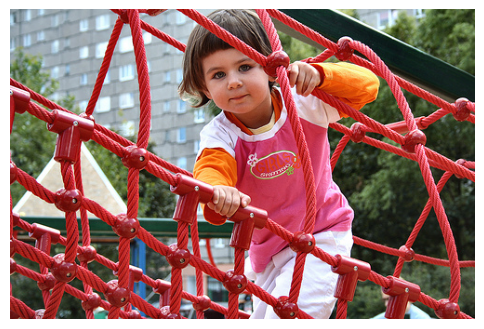

Captions for image 1007320043_627395c3d8.jpg:
- A child playing on a rope net .
- A little girl climbing on red roping .
- A little girl in pink climbs a rope bridge at the park .
- A small child grips onto the red ropes at the playground .
- The small child climbs on a red ropes on a playground .


In [12]:
image_path = "1007320043_627395c3d8.jpg"

# Select rows based on the condition
selected_rows = cap_df[cap_df["image"].str.contains(image_path)]

# Check if any rows are selected
if not selected_rows.empty:
    # Show image
    plt.figure(figsize=(6, 6))
    img = plt.imread("Dataset/Images/" + image_path)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

    # Print all captions for the selected image
    print(f"Captions for image {image_path}:")
    for index, row in selected_rows.iterrows():
        caption = row["caption"]
        print(f"- {caption}")

else:
    print(f"Image {image_path} not found in the dataset.")

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
# Clean Text

lemmatizer = WordNetLemmatizer()
def clean_text(sent):
    sent = sent.lower()
    sent = re.sub("[0-9]","",sent)     # digits
    sent = re.sub("https?://\S+","",sent)     # URLs
    sent = re.sub("@\S+","",sent)     # @'s
    sent = re.sub("[+-/*,':%$#&!_<>(){}^]","",sent)     # special characters
    sent = re.sub(" +"," ",sent)     # extra spaces
    words = nltk.word_tokenize(sent)
    stop_words = set(nltk.corpus.stopwords.words("english"))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    sent = ' '.join(words)
    sent = "[start] " + sent + " [end]"
    return sent


cap_df["caption"] = cap_df["caption"].apply(lambda x: clean_text(x))

In [15]:
# Create Sentence Vectorizer
sent_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", output_sequence_length = sequence_length
)
sent_vectorization.adapt(cap_df["caption"].values)

# Index to Word mapping
index_to_word = dict()
for index, word in enumerate(sent_vectorization.get_vocabulary()):
    index_to_word[index] = word

In [16]:
# Define Dataset Function
def image_read(path):
    path = "Dataset/Images/" + path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = channels)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)
    return img

def process_text(sentences):
    caption_vector = sent_vectorization(sentences)
    return caption_vector

def create_dataset(images, texts, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, texts))
    dataset = dataset.map(lambda a, b : (image_read(a), process_text(b)), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [17]:
cap_df = cap_df.sample(frac=1, random_state=42)
split_index = int(0.8 * len(cap_df))

trn = cap_df[:split_index]
tst = cap_df[split_index:]

print("Training set shape:", trn.shape)
print("Testing set shape:", tst.shape)

# Create datasets using create_dataset
train = create_dataset(trn["image"].values, trn["caption"].values, batch_size)
test = create_dataset(tst["image"].values, tst["caption"].values, batch_size)

Training set shape: (32364, 2)
Testing set shape: (8091, 2)


In [18]:
# EfficientNet for image context
base_model = EfficientNetV2M(input_shape = (img_size, img_size, 3), include_top=False, weights="imagenet")
base_model.trainable = False
base_model_out = base_model.output
base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
cnn_model = Model(base_model.input, base_model_out)

# CNN_encoder for fine tuning
class CNN_encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_encoder, self).__init__()
        self.dense = Dense(embedding_dim, activation = "softmax")

    def call(self, img_context):
        x = self.dense(img_context)
        return x

214201816/214201816 [==============================] - 1s 0us/step


In [20]:
# Attention Class
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.S = Dense(1)

    def call(self, features, hidden):
        hidden_state_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_state_with_time_axis))

        score = self.S(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis = 1)

        context_vector = features * attention_weights
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        return context_vector

In [21]:
# RNN_encoder for sentence creation
class RNN_decoder(tf.keras.Model):
    def __init__(self, embedding_size, vocab_size, units):
        super(RNN_decoder, self).__init__()
        self.units = units
        self.attention = Attention(units)
        self.embedding = Embedding(vocab_size, embedding_size)
        self.gru = GRU(units,
                       return_sequences = True,
                       return_state = True)
        self.dense1 = Dense(units)
        self.dense2 = Dense(vocab_size)

    def call(self, x, features, hidden_state):
        context_vector = self.attention(features, hidden_state)
        x = self.embedding(x)
        x = tf.concat([x, tf.expand_dims(context_vector, 1)], axis = -1)
        x, states = self.gru(x)
        x = self.dense1(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dense2(x)
        return x, states

In [22]:
encoder = CNN_encoder(embedding_dim)
decoder = RNN_decoder(embedding_dim, vocab_size, units)

optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# Custom loss function
# Ignores the prediction of [mask] values
def loss_fn(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    final_loss = loss_obj(real, pred)

    mask = tf.cast(mask, dtype = final_loss.dtype)
    final_loss *= mask

    return tf.reduce_sum(final_loss)

In [23]:
# For each Batch
def train_step(img_tensor, target):
    loss = 0
    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])] * target.shape[0], 1)
    hidden_state = tf.zeros((batch_size, units))

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            pred, hidden_state = decoder(dec_input, features, hidden_state)
            loss += loss_fn(target[:, i], pred)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    return total_loss

In [24]:
# Train model
for epoch in range(epochs):
    total_loss = 0

    for imgs, target in train:
        img_tensor = cnn_model(imgs)
        loss = train_step(img_tensor, target)
        total_loss += loss

    print("##### Epoch {} #####".format(epoch + 1))
    print("Loss is {}".format(total_loss / len(trn)),"\n")

##### Epoch 1 #####
Loss is 1.3761762380599976 

##### Epoch 2 #####
Loss is 1.135621190071106 

##### Epoch 3 #####
Loss is 1.0446369647979736 

##### Epoch 4 #####
Loss is 0.9883063435554504 

##### Epoch 5 #####
Loss is 0.9466732740402222 

##### Epoch 6 #####
Loss is 0.9116839170455933 

##### Epoch 7 #####
Loss is 0.8813828825950623 

##### Epoch 8 #####
Loss is 0.8546096086502075 

##### Epoch 9 #####
Loss is 0.8312581777572632 

##### Epoch 10 #####
Loss is 0.810426652431488 

##### Epoch 11 #####
Loss is 0.7917852401733398 



In [25]:
# Save weights of Model and Vectorizer
encoder.save_weights("encoder_weights.h5")
decoder.save_weights("decoder_weights.h5")

sent_vectorization_config = sent_vectorization.get_config()
sent_vectorization_weights = sent_vectorization.get_weights()

with open("sent_vectorizer.pkl", "wb") as f:
    pickle.dump({'config': sent_vectorization_config, 'weights': sent_vectorization_weights}, f)

In [26]:
# Caption function for evaluation
def caption(path):
    img = image_read(path)
    img = tf.expand_dims(img, 0)
    context = cnn_model(img)
    features = encoder(context)

    dec_input = tf.expand_dims([int(sent_vectorization('[start]')[0])], 0)
    hidden_state = tf.zeros((1, units))
    sentence = []
    for i in range(20):
        pred, hidden_state = decoder(dec_input, features, hidden_state)
        predicted_id = np.argmax(tf.reshape(pred, -1))
        predicted_word = index_to_word[predicted_id]
        sentence.append(predicted_word)

        if predicted_word == "end":
            return ' '.join(sentence[:-1])

        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(sentence)

man wearing red shirt riding street 

man sitting boat 

man wearing red shirt standing front large rock face 

two dog running beach 

girl bathing suit surfing 



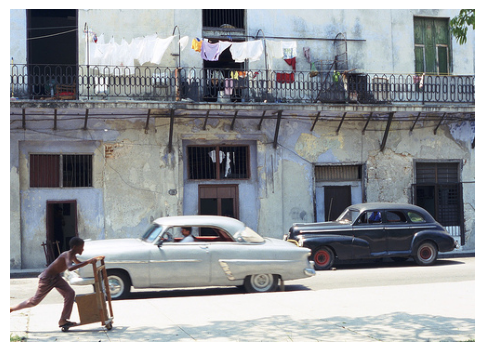

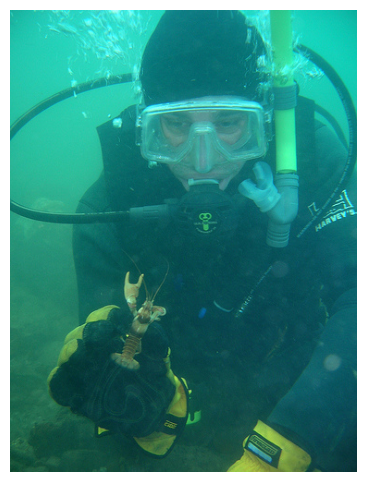

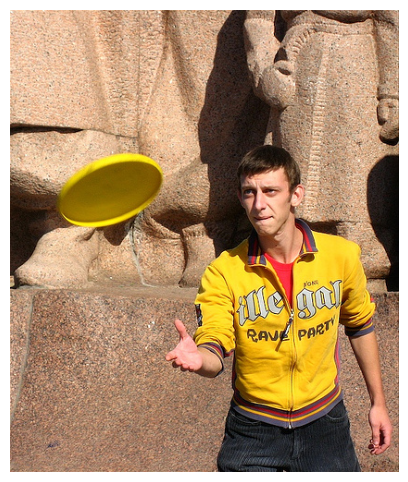

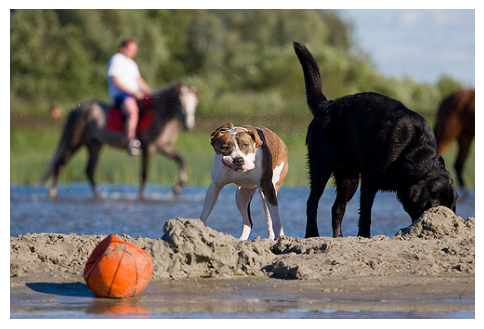

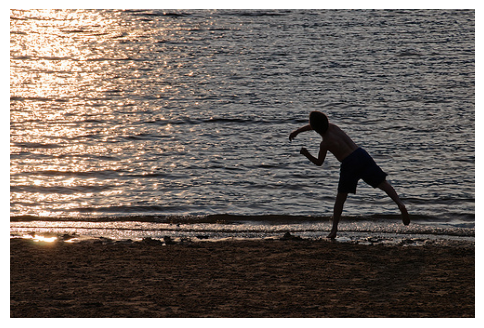

In [27]:
import matplotlib.pyplot as plt

def display_image_and_caption(dataset, index):
    # Display image
    plt.figure(figsize=(6, 6))
    img_path = "Dataset/Images/" + dataset["image"].iloc[index]
    img = plt.imread(img_path)
    plt.axis("off")
    plt.imshow(img)

    # Generate and print caption
    pred = caption(dataset["image"].iloc[index])
    print(pred, "\n")

# Assuming tst is your dataset
for i in range(5):  # Display the first 5 images and captions as an example
    display_image_and_caption(tst, i)

In [28]:
# Bleu score function
def BLEU_score(real, pred):
    x = real.split()
    y = pred.split()

    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([x[1:-1]], y, smoothing_function = smooth)
    return bleu


In [29]:
# Evaluate on Test Data
# BLEU score the Higher the Better
bleu = 0
num_batches = 0
for i in range(tst.shape[0]):
    num_batches+=1
    test_img = tst["image"].iloc[i]  # Use index i to iterate over all rows
    test_target = tst["caption"].iloc[i]
    prediction = caption(test_img)
    bleu += BLEU_score(test_target, prediction)

print("BLEU score is {}".format(bleu / num_batches))

BLEU score is 0.04605048450721198
